In [57]:
import pandas as pd
import numpy as np

In [58]:
SEX = {"male": 0, "female": 1}


def delete_unused_columns(data):
    return data.drop(["ID", "NumberOfPersons", "global_id", "Year", "Month"], axis=1).drop_duplicates()


def clear_names(data):
    for names in data:
        for name in names.split(", "):
            if name != "Name":
                yield name.strip()


def get_names_df(data):
    return pd.DataFrame({"Name": list(clear_names(data))}).drop_duplicates()

In [59]:
# boys table
boys = get_names_df(delete_unused_columns(pd.read_csv("boys.csv", sep=";", encoding="utf-8"))["Name"])
boys["Sex"] = SEX["male"]
boys

,Name,Sex
0,Александр,0
1,Михаил,0
2,Иван,0
3,Максим,0
4,Артём,0
...,...,...
196,Эмирхан,0
197,Армен,0
198,Абдуллах,0
199,Аарон,0


In [60]:
# girls table
girls = get_names_df(delete_unused_columns(pd.read_csv("girls.csv", sep=";", encoding="utf-8"))["Name"])
girls["Sex"] = SEX["female"]
girls

,Name,Sex
0,Мария,1
1,Анастасия,1
2,Анна,1
3,Варвара,1
4,Виктория,1
...,...,...
202,Айбийке,1
203,Ясина,1
205,Луна,1
206,Златослава,1


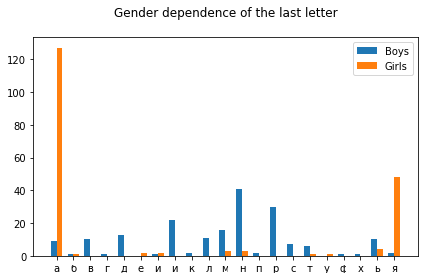

In [61]:
# graphic:
import matplotlib.pyplot as plt


def get_count_last_let(data):
    letters = {letter: 0 for letter in map(chr, range(ord("а"), ord("я") + 1))}
    for name in data["Name"]:
        letters[name[-1]] += 1
    return letters


b = get_count_last_let(boys)
g = get_count_last_let(girls)
letters = []
for let in map(chr, range(ord("а"), ord("я") + 1)):
    if not any((b[let], g[let])):
        del b[let]
        del g[let]
    else:
        letters.append(let)

x = np.arange(len(letters))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, list(map(lambda x: b[x], letters)), width, label="Boys")
rects2 = ax.bar(x + width / 2, list(map(lambda x: g[x], letters)), width, label="Girls")

ax.set_title("Gender dependence of the last letter\n")
ax.set_xticks(x)
ax.set_xticklabels(letters)
ax.legend()

fig.tight_layout()

plt.savefig('graph.png')
plt.show()

In [62]:
# union
df = pd.concat([boys, girls], ignore_index=True)
df

,Name,Sex
0,Александр,0
1,Михаил,0
2,Иван,0
3,Максим,0
4,Артём,0
...,...,...
373,Айбийке,1
374,Ясина,1
375,Луна,1
376,Златослава,1


In [87]:
def generate_features(name):
    name = name.lower()
    return {
        "last": name[-1],
        "last2": name[-2:],
        "last3": name[-3:],
        "first": name[0],
        "first2": name[:2],
        "first3": name[:3],
    }

In [88]:
features = np.vectorize(generate_features)

dfX = features(df["Name"])
dfY = df["Sex"]

In [101]:
from sklearn.model_selection import train_test_split

dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX, dfY, test_size=0.3, random_state=42)
dfX_train

array([{'last': 'е', 'last2': 'ке', 'last3': 'йке', 'first': 'а', 'first2': 'ай', 'first3': 'айб'},
       {'last': 'н', 'last2': 'ин', 'last3': 'мин', 'first': 'я', 'first2': 'яс', 'first3': 'ясм'},
       {'last': 'а', 'last2': 'на', 'last3': 'ина', 'first': 'м', 'first2': 'ма', 'first3': 'мад'},
       {'last': 'а', 'last2': 'са', 'last3': 'сса', 'first': 'м', 'first2': 'ме', 'first3': 'мел'},
       {'last': 'р', 'last2': 'ар', 'last3': 'дар', 'first': 'э', 'first2': 'эл', 'first3': 'эль'},
       {'last': 'а', 'last2': 'ла', 'last3': 'ила', 'first': 'л', 'first2': 'лю', 'first3': 'люд'},
       {'last': 'м', 'last2': 'им', 'last3': 'лим', 'first': 'к', 'first2': 'кл', 'first3': 'кли'},
       {'last': 'я', 'last2': 'ня', 'last3': 'оня', 'first': 'с', 'first2': 'со', 'first3': 'сон'},
       {'last': 'а', 'last2': 'ка', 'last3': 'ика', 'first': 'в', 'first2': 'ве', 'first3': 'вер'},
       {'last': 'к', 'last2': 'рк', 'last3': 'арк', 'first': 'м', 'first2': 'ма', 'first3': 'мар'},


In [102]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()
dv.fit_transform(dfX_train)

<264x566 sparse matrix of type '<class 'numpy.float64'>'
	with 1584 stored elements in Compressed Sparse Row format>

In [103]:
from sklearn.tree import DecisionTreeClassifier

dclf = DecisionTreeClassifier()
my_xfeatures = dv.transform(dfX_train)
dclf.fit(my_xfeatures, dfY_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [104]:
print("Score:", dclf.score(dv.transform(dfX_test), dfY_test))

Score: 0.8947368421052632


In [105]:
def genderpredictor(a):
    name = [a]
    transform_dv = dv.transform(features(name))
    vector = transform_dv.toarray()
    return f"Уважаем{'ый' if dclf.predict(vector) == SEX['male'] else 'ая'} {name[0]}"

In [106]:
names = [
    "Глеб",
    "Дарья",
    "Елизавета",
    "Екатерина",
    "Георгий",
    "Михаил",
    "Анастасия",
    "Мария",
    "Сергей",
    "Дмитрий",
    "Николай",
    "Игорь",
    "Светлана",
]

for name in names:
    print(genderpredictor(name))

Уважаемый Глеб
Уважаемая Дарья
Уважаемая Елизавета
Уважаемая Екатерина
Уважаемый Георгий
Уважаемый Михаил
Уважаемая Анастасия
Уважаемая Мария
Уважаемый Сергей
Уважаемый Дмитрий
Уважаемый Николай
Уважаемый Игорь
Уважаемая Светлана
